# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

ModuleNotFoundError: No module named 'sklearn'

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
print(data_train)
print(data_test)

Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
           )
Dataset SVHN
    Number of datapoints: 26032
    Root location: ./data/
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
           )


Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
print(data_size)
validation_split = .2
print(validation_split)
split = int(np.floor(validation_split * data_size))
print(split)
indices = list(range(data_size))
print(indices)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
print(train_indices)
print(val_indices)
train_sampler = SubsetRandomSampler(train_indices)
print(train_sampler)
val_sampler = SubsetRandomSampler(val_indices)
print(val_sampler)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
print(len(train_loader.dataset))
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
print(len(val_loader.dataset))

73257
0.2
14651
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [7]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [8]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [11]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    #scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        #print(loss_history)
        #print(train_history)
        #print(val_history)
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
      
    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            predicted = model(images)
            #_, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.argmax(1) == labels).type(torch.float).sum().item()
    accuracy = correct / total
    
    return accuracy
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 0.486317, Train accuracy: 0.848411, Val accuracy: 0.845608
Average loss: 0.482491, Train accuracy: 0.848155, Val accuracy: 0.847178
Average loss: 0.481951, Train accuracy: 0.850510, Val accuracy: 0.846222


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [23]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

[2.1582729816436768]
[0.20439886701020374]
[0.2466725820763088]
Average loss: 2.158273, Train accuracy: 0.204399, Val accuracy: 0.246673
[2.1582729816436768, 2.042710542678833]
[0.20439886701020374, 0.25813056683616015]
[0.2466725820763088, 0.28025390758310015]
Average loss: 2.042711, Train accuracy: 0.258131, Val accuracy: 0.280254
[2.1582729816436768, 2.042710542678833, 1.9609650373458862]
[0.20439886701020374, 0.25813056683616015, 0.29288810019451933]
[0.2466725820763088, 0.28025390758310015, 0.31922735649443723]
Average loss: 1.960965, Train accuracy: 0.292888, Val accuracy: 0.319227
[2.1582729816436768, 2.042710542678833, 1.9609650373458862, 1.8784598112106323]
[0.20439886701020374, 0.25813056683616015, 0.29288810019451933, 0.33607480462751255]
[0.2466725820763088, 0.28025390758310015, 0.31922735649443723, 0.35656269196641865]
Average loss: 1.878460, Train accuracy: 0.336075, Val accuracy: 0.356563
[2.1582729816436768, 2.042710542678833, 1.9609650373458862, 1.8784598112106323, 1.8

Добавьте слой с Batch Normalization

In [165]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d
#inplace=True

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
                )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 20)

Average loss: 2.081214, Train accuracy: 0.304133, Val accuracy: 0.433759
Average loss: 1.786899, Train accuracy: 0.475719, Val accuracy: 0.532455
Average loss: 1.643968, Train accuracy: 0.547145, Val accuracy: 0.587332
Average loss: 1.552427, Train accuracy: 0.582074, Val accuracy: 0.603986
Average loss: 1.488393, Train accuracy: 0.602720, Val accuracy: 0.619821
Average loss: 1.443627, Train accuracy: 0.617138, Val accuracy: 0.630401
Average loss: 1.409287, Train accuracy: 0.631710, Val accuracy: 0.590335
Average loss: 1.385486, Train accuracy: 0.642357, Val accuracy: 0.650263
Average loss: 1.370797, Train accuracy: 0.649712, Val accuracy: 0.654426
Average loss: 1.358052, Train accuracy: 0.658414, Val accuracy: 0.657293
Average loss: 1.352576, Train accuracy: 0.664761, Val accuracy: 0.667599
Average loss: 1.347147, Train accuracy: 0.670699, Val accuracy: 0.687393
Average loss: 1.346510, Train accuracy: 0.674965, Val accuracy: 0.684117
Average loss: 1.345845, Train accuracy: 0.679828, V

Добавьте уменьшение скорости обучения по ходу тренировки.

In [166]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
                )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 20)

Average loss: 2.057751, Train accuracy: 0.316981, Val accuracy: 0.441199
Average loss: 1.754459, Train accuracy: 0.482152, Val accuracy: 0.519828
Average loss: 1.620409, Train accuracy: 0.541480, Val accuracy: 0.574022
Average loss: 1.540220, Train accuracy: 0.573337, Val accuracy: 0.578254
Average loss: 1.489291, Train accuracy: 0.598249, Val accuracy: 0.615658
Average loss: 1.466848, Train accuracy: 0.609835, Val accuracy: 0.631766
Average loss: 1.445183, Train accuracy: 0.619937, Val accuracy: 0.635929
Average loss: 1.427387, Train accuracy: 0.627666, Val accuracy: 0.638728
Average loss: 1.412177, Train accuracy: 0.635583, Val accuracy: 0.652106
Average loss: 1.393922, Train accuracy: 0.645565, Val accuracy: 0.663299
Average loss: 1.384833, Train accuracy: 0.650531, Val accuracy: 0.662003
Average loss: 1.376688, Train accuracy: 0.653175, Val accuracy: 0.665961
Average loss: 1.369832, Train accuracy: 0.658038, Val accuracy: 0.664869
Average loss: 1.363193, Train accuracy: 0.661878, V

In [10]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 10),
                )
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 12)

/Users/dimasyrovitsky/opt/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Average loss: 1.252051, Train accuracy: 0.592192, Val accuracy: 0.695038
Average loss: 0.831558, Train accuracy: 0.738883, Val accuracy: 0.777490
Average loss: 0.739723, Train accuracy: 0.768095, Val accuracy: 0.788137
Average loss: 0.638464, Train accuracy: 0.800157, Val accuracy: 0.813665
Average loss: 0.609214, Train accuracy: 0.808569, Val accuracy: 0.822401
Average loss: 0.559223, Train accuracy: 0.824625, Val accuracy: 0.834551
Average loss: 0.546343, Train accuracy: 0.828123, Val accuracy: 0.836189
Average loss: 0.522042, Train accuracy: 0.837252, Val accuracy: 0.839738
Average loss: 0.510854, Train accuracy: 0.840238, Val accuracy: 0.842059
Average loss: 0.501661, Train accuracy: 0.843787, Val accuracy: 0.842400
Average loss: 0.497174, Train accuracy: 0.843292, Val accuracy: 0.843492
Average loss: 0.489706, Train accuracy: 0.848872, Val accuracy: 0.845676


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [134]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful! batch_size=batch_size,
    val_sam = SubsetSampler(indices)
    load = torch.utils.data.DataLoader(dataset, batch_size=len(indices),
                                         sampler=val_sam)
    with torch.no_grad():
        for data in load:
            images, ground_truth = data
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)
     
    #print(len(load.dataset))
    #print(len(val_indices))
    return predictions, ground_truth
# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(list(gt), list(predictions)))

In [139]:
len(predictions)

14651

In [140]:
len(gt)

14651

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

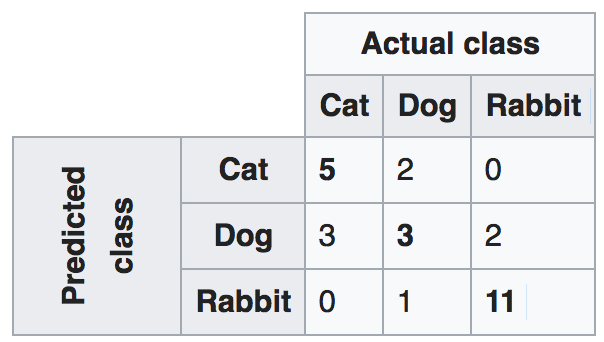

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

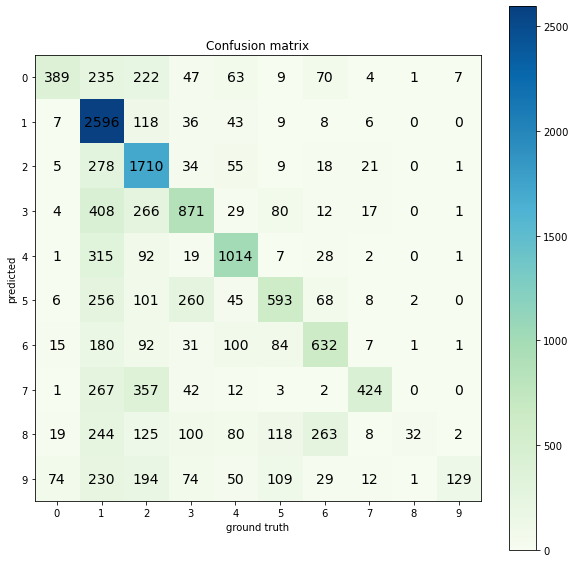

In [112]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    #confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    #return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return confusion_matrix(ground_truth, predictions)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

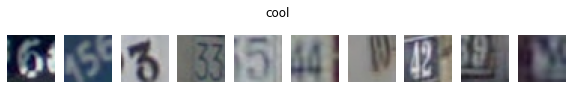

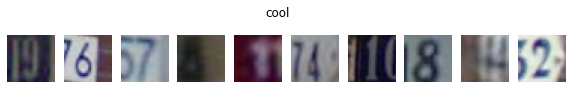

In [157]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    l = []
    val_samp = Sampler(np.array(val_indices))
    val_load = torch.utils.data.DataLoader(data, sampler=val_samp)
    for i, x in enumerate(groud_truth):
        if groud_truth[i] == gt_class and predictions[i] == predicted_class:
            l.append(i)
    visualize_images(l, data, title='cool', max_num=10)
    #raise Exception("Not implemented")


visualize_predicted_actual(7, 9, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# Experiment here!

In [12]:
# Как всегда, в конце проверяем на test set
test_data_size = data_test.data.shape[0]
test_indices = list(range(test_data_size))
test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, sampler=test_sampler)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8208
